<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Посимвольная-токенизация">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Посимвольная токенизация
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-символов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация символов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Формирование-датасета">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Формирование датасета
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Построение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Построение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Обучение-модели">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.5-Генерация-текста">
                            <span class="toc-item-num">3.5&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Simple RNN (посимвольная)

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. RNN с посимвольной токенизацией (текущий файл)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](unidirectional_LSTM_BPE.ipynb)
4. [Двунаправленная LSTM](bidirectional_LSTM.ipynb)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np
import os

import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow import keras

import keras.layers as l

from keras import models, callbacks, utils, losses

# custom funcs
import utils.web_scrapping as web
import utils.process_checking as check
import utils.data_preprocessing as data_prep
import utils.charts_plotting as chart
import utils.predictions_making as pred

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Формирование/загрузка набора данных в зависимости от его наличия:

In [2]:
data = web.load_data('https://hpmor.ru/', 'hpmor.txt')

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [3]:
data[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов и предложений в тексте:

In [4]:
check.print_total(data)

Всего слов: 559791
Всего предложений: 37351


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Посимвольная токенизация

### 3.1 Токенизация символов

Получение словаря уникальных символов текста:

In [5]:
vocabulary = np.array(sorted(set(data)))

Выведение на экран уникальных символов текста:

In [6]:
vocabulary

array(['\n', ' ', '!', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '=', '?', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', '×', 'é', 'ð', 'ó',
       'þ', '́', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к',
       'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч',
       'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'ѝ', '–', '—', '’',
       '“', '”', '„', '…', '№', '∀', '∄', '−'], dtype='<U1')

Формирование словаря токенов:

In [7]:
tokenizer_word_to_index = {char: i for i, char in enumerate(vocabulary)}
tokenizer_index_to_word = {i: char for i, char in enumerate(vocabulary)}

Выведение на экран количества токенов в словаре:

In [8]:
print('Всего символов:', len(tokenizer_word_to_index))

Всего символов: 112


Выведение на экран начала словаря токенов:

In [9]:
check.print_tokenizer_vocabulary(tokenizer_word_to_index)

[('\n', 0),
 (' ', 1),
 ('!', 2),
 ('#', 3),
 ('$', 4),
 ('%', 5),
 ('&', 6),
 ('(', 7),
 (')', 8),
 ('*', 9)]

Выведение на экран начала словаря токенов:

In [10]:
check.print_tokenizer_vocabulary(tokenizer_index_to_word)

[(0, '\n'),
 (1, ' '),
 (2, '!'),
 (3, '#'),
 (4, '$'),
 (5, '%'),
 (6, '&'),
 (7, '('),
 (8, ')'),
 (9, '*')]

---

### 3.2 Формирование датасета

Преобразование текста в вектор на основе токенов:

In [11]:
vector = np.array([tokenizer_word_to_index[char] for char in data])

Выведение на экран части исходного текста и его векторного представления:

In [12]:
check.print_init_vector(data, vector)

Исходный текст:
 гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не 

Векторное представление:
 [70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80 72]


Формирование набора данных из срезов вектора текста:

In [13]:
vector = Dataset.from_tensor_slices(vector)

Задание констант:

In [14]:
VOCAB_LEN = len(tokenizer_word_to_index.items())
BATCH_SIZE = 100

Формирование последовательностей по заданному количеству символов:

In [15]:
sequences = vector.batch(BATCH_SIZE, drop_remainder=True) 

Задание констант:

In [16]:
BATCHES_PER_EPOCH = len(sequences) // BATCH_SIZE

Формирование датасета:

In [17]:
dataset = sequences.map(data_prep.get_features_target)

Выведение на экран первой входящей последовательности и соответствующего ей сдвига:

In [18]:
for features, target in dataset.take(1):
    check.print_single_element(
        features.numpy(), 
        target.numpy(), 
        tokenizer_index_to_word, 
        take_random=False,
        char=True
    )

Признаки (99,):
[70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80]

Перевод в текст:
гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж н

Целевой признак (99,):
[67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67 89
 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78 75
 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50 47
 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86 73
  1 80 72]

Перевод в текст:
арри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не



Формирование датасета с делением на батчи:

In [19]:
data = dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)

Выведение на экран размерностей первой входящей последовательности и соответствующего ей сдвига:

In [20]:
for features, target in data.take(1):
    check.print_single_dimension(features, target)

Размерность признаков: (100, 99)
Размерность целевого признака: (100, 99)


---

### 3.3 Построение модели

Задание модели:

In [21]:
model = keras.Sequential([
    l.Embedding(len(vocabulary), BATCH_SIZE, batch_input_shape=[BATCH_SIZE, None]),
    l.LSTM(512, return_sequences=True, stateful=True),
    l.LSTM(512, return_sequences=True, stateful=True),
    l.Dense(len(vocabulary))
])

Выведение на экран таблицы поведения параметров на словях нейросети:

In [22]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (100, None, 100)          11200     
                                                                 
 lstm (LSTM)                 (100, None, 512)          1255424   
                                                                 
 lstm_1 (LSTM)               (100, None, 512)          2099200   
                                                                 
 dense (Dense)               (100, None, 112)          57456     
                                                                 
Total params: 3,423,280
Trainable params: 3,423,280
Non-trainable params: 0
_________________________________________________________________


Проверка наличия папки для хранения изображений:

In [23]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

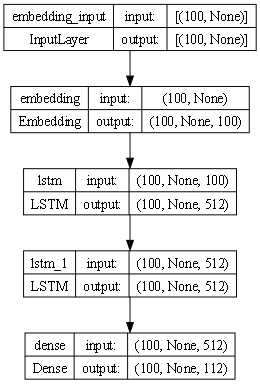

In [24]:
utils.plot_model(model, 'images/rnn_char_model.png', show_shapes=True, dpi=70)

Проверка модели на восприятие датасета на примере первой последовательности:

In [25]:
for features, target in data.take(1):
    check.print_single_test(model, features, target, tokenizer_index_to_word)

Размерность признаков: (100, 99)
Размерность предсказаний: (100, 99, 112)
Размерность тензора с 1 индексом классов (99, 1)
Предсказанный класс: 63 (ð)


---

### 3.4 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [26]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [27]:
path_checkpoints = 'checkpoints/rnn_char'

Проверка наличия папки для хранения контрольных точек:

In [28]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [29]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

Подготовка модели к обучению:

In [30]:
model.compile(
    optimizer='adam', 
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Обучение модели:

In [31]:
history = model.fit(
    data, 
    epochs=20, 
    verbose=1,
    steps_per_epoch=BATCHES_PER_EPOCH, 
    callbacks=[checkpoint_callback]
)

Epoch 1/20
360/360 [==============================] - 653s 2s/step - loss: 2.7779 - accuracy: 0.2289
Epoch 2/20
360/360 [==============================] - 674s 2s/step - loss: 2.0753 - accuracy: 0.3977
Epoch 3/20
360/360 [==============================] - 672s 2s/step - loss: 1.6919 - accuracy: 0.5006
Epoch 4/20
360/360 [==============================] - 669s 2s/step - loss: 1.5280 - accuracy: 0.5424
Epoch 5/20
360/360 [==============================] - 668s 2s/step - loss: 1.4402 - accuracy: 0.5650
Epoch 6/20
360/360 [==============================] - 660s 2s/step - loss: 1.3827 - accuracy: 0.5801
Epoch 7/20
360/360 [==============================] - 660s 2s/step - loss: 1.3406 - accuracy: 0.5914
Epoch 8/20
360/360 [==============================] - 661s 2s/step - loss: 1.3075 - accuracy: 0.6005
Epoch 9/20
360/360 [==============================] - 656s 2s/step - loss: 1.2803 - accuracy: 0.6081
Epoch 10/20
360/360 [==============================] - 658s 2s/step - loss: 1.2570 - accura

Выведение на экран графика значений функции потерь:

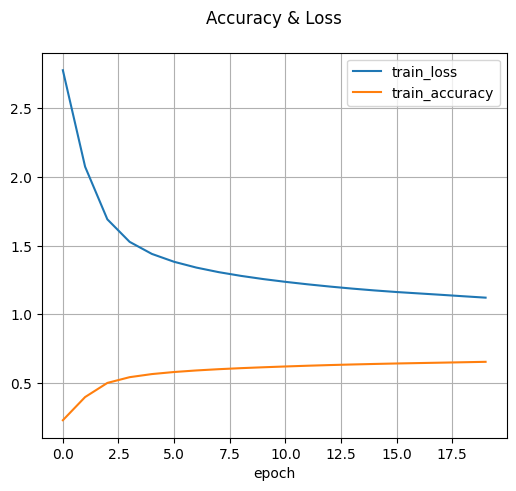

In [32]:
chart.plot_loss_acc(history)

Сброс состояния модели:

In [33]:
model.reset_states()

---

### 3.5 Генерация текста

Выведение на экран результата предсказаний:

In [34]:
pred.predict_next(
    sample='гарри поттер', 
    model=model,
    tokenizer=tokenizer_word_to_index,
    vocabulary=tokenizer_index_to_word,
    n_next=1000, 
    temperature=0.6,
    batch_size=BATCH_SIZE
)

'гарри поттера не знал, что профессор квиррелл следовал принцип большинство из себя поразилась, что она покачала головой. — ты понимаешь, что я надеялся, что вернётся с ними. — я понимаю, что я скажу, что это значит, что делать то, что происходит именно такое благодарность по спине. она выглядела оставалась право выражать себя в своей собственных состоянии создать лушаю одеяному человеку, что с точки зрения постоянно умёны с отчаянием уменьшающих настолько уменица, и всё же на самом деле не сможет быть заполнились внешность в камине старшей по патронусе, который пробустил невинный конец почти защититься от него, и макгонагалл произносила бы и на моих мантии с тремя стандартной старосов в безопасности волшебника, просто снова захочется потерять гораздо потребовалось ужасно на магической марествованию в одиночестве, что пожирателей смерти не было то, что она не хотела, чтобы эти слова в обычную комнату, но не было впечатление на стол дамблдора. он держал твоё мнение, что он не смог бы сд

Выведение на экран результата предсказаний:

In [35]:
pred.predict_next(
    sample='гарри поттер', 
    model=model,
    tokenizer=tokenizer_word_to_index,
    vocabulary=tokenizer_index_to_word,
    n_next=1000, 
    temperature=0.6,
    batch_size=BATCH_SIZE
)

'гарри поттер. но всё же начала завтрашать сознание за ней, подобные памяти — и это имеют ли гарри поттера по всей серьёзности остался в шрамах. — вы… мисс грейнджер, — сказала она неверной в том, что он чувствовал, как позволяет открыть тайную сторону, чтобы он хотел дать четыре света, которая видела смерти, чтобы представить тебя на профессоре квиррелле, и потому на это окажется не смог бы на случай, если все удивились и отражалась самого балсона, она остановилась и покажет заговорил в коридорам и профессор квиррелл подумал, что случилось невозможно. так как на самом деле был бы способен направиться между нами и самого насколько последнюю огне и хотел бы уначтожить руку в начале под оказалась вслед на гермиону. казалось, оно не понимали о всех учеников на лице. на самом деле профессор квиррелл даже не замолчал, но гарри не смог бы заглушил в комнату и вся открыть свою палочку и прошла в центральной серебрести самого себя, и профессор квиррелл умолкнула и волди начал получить книги, к

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Результаты проведённого эксперимента можно улучшить за счёт большего числа итераций обучения и усложения модели посредством изменения её слоёв. Однако эти этапы возможны только при наличии соответствующих технических средств.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>